### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Importing the dataset

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2021-05-14 14:47:34--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  32.6MB/s    in 5.6s    

2021-05-14 14:47:40 (29.1 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [ ]:
!tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
metadata = unpickle('cifar-10-batches-py/batches.meta')[b'label_names']

In [ ]:
index2label = {
    index: label.decode('ascii') for index, label in enumerate(metadata)
}
label2index = {val: key for key, val in index2label.items()}
index2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
data = unpickle('cifar-10-batches-py/data_batch_1')
print(data.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [ ]:
data_array = data[b'data']
data_array = np.reshape(data_array, (10000, 3, 1024))

In [ ]:
data_labels = data[b'labels']
data_labels = np.array(data_labels)

In [ ]:
data_array_agg = np.array([])
data_labels_agg = np.array([])
base_path = 'cifar-10-batches-py'
file_names = os.listdir(base_path)
for file_name in file_names:
    if file_name.startswith('data_batch'):

        data = unpickle(os.path.join(base_path, file_name))
        data_array = data[b'data']
        data_array = np.reshape(data_array, (10000, 3, 1024))
        data_labels = data[b'labels']
        data_labels = np.array(data_labels)
        if data_array_agg.shape == (0, ):
            data_array_agg = data_array
            data_labels_agg = data_labels
        else: 
            data_array_agg = np.append(data_array_agg, data_array, axis=0)
            data_labels_agg = np.append(data_labels_agg, data_labels, axis=0)
data_array_agg = data_array_agg.reshape((-1, 3, 32, 32))

In [ ]:
data_array_agg.shape, data_labels_agg.shape

((50000, 3, 32, 32), (50000,))

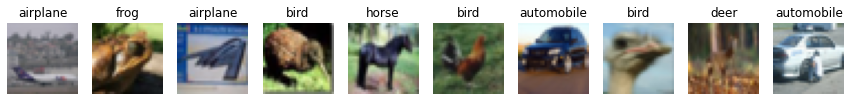

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(15, 10))
for i in range(10):
    sample_image = data_array_agg[i].T
    sample_image = np.swapaxes(sample_image, 0, 1)
    axs[i].imshow(sample_image)
    axs[i].set_title(index2label[data_labels_agg[i]])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)

In [ ]:
test_data = unpickle(os.path.join(base_path, 'test_batch'))
test_data_array = test_data[b'data']
test_data_array = np.reshape(test_data_array, (10000, 3, 1024))
test_data_labels = test_data[b'labels']
test_data_labels = np.array(test_data_labels)
test_data_array = test_data_array.reshape((-1, 3, 32, 32))

In [ ]:
test_data_array.shape, test_data_labels.shape

((10000, 3, 32, 32), (10000,))

### Converting the numpy arrays to the torch Data

In [ ]:
def to_dataloader(data_array_agg, data_labels_agg, batch_size, normalizer=255.0):
    target = torch.tensor(data_labels_agg)
    data_array_agg = data_array_agg / normalizer
    data = torch.tensor(data_array_agg.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=batch_size)
    return data_loader

In [ ]:
train_data_loader = to_dataloader(data_array_agg, data_labels_agg, batch_size=128)
test_data_loader = to_dataloader(test_data_array, test_data_labels, batch_size=128)

In [ ]:
for data_array, target in train_data_loader:
    print('the shape of the data array: {}'.format(data_array.shape))
    print('the shape of the target array: {}'.format(target.shape))
    break

the shape of the data array: torch.Size([128, 3, 32, 32])
the shape of the target array: torch.Size([128])


### Loading the dataset using Pytorch datasets

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Building the Models

In [ ]:
# model with 3 convolutional hidden layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(self.base(x))
        out = self.pool(self.layer1(out))
        out = self.pool(self.layer2(out))

        out = out.reshape((out.size(0), -1))
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        return out

### Other Models

In [ ]:
# model with 3 convolutional hidden layers and Sigmoid Activation Function
class Net_sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(torch.sigmoid(self.base(x)))
        out = self.pool(torch.sigmoid(self.layer1(out)))
        out = self.pool(torch.sigmoid(self.layer2(out)))

        out = out.reshape((out.size(0), -1))
        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        out = torch.sigmoid(self.fc4(out))
        out = self.fc5(out)
        return out

In [ ]:
# model with 3 convolutional hidden layers and tanh Activation Function
class Net_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(torch.tanh(self.base(x)))
        out = self.pool(torch.tanh(self.layer1(out)))
        out = self.pool(torch.tanh(self.layer2(out)))

        out = out.reshape((out.size(0), -1))
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out

In [ ]:
# model with 2 convolutional hidden layers
class Net_2_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(self.base(x))
        out = self.pool(self.layer1(out))

        out = out.reshape((out.size(0), -1))
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        return out

In [ ]:
# model with 1 convolutional hidden layers
class Net_1_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(self.base(x))
        
        out = out.reshape((out.size(0), -1))
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        return out

In [ ]:
# model with 0 convolutional hidden layers
class Net_0_layer(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = x.reshape((x.size(0), -1))
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        return out

### Testing the output and the dimensionalities

In [ ]:
temp = Net()
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
out = temp(images)
out.shape

torch.Size([128, 10])

In [ ]:
temp = Net_0_layer()
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
out = temp(images)
out.shape

torch.Size([128, 10])

### Utility Functions for Training and Evaluating the Model and also Visualization

In [ ]:
def plot_train_test_acc(train_acc, test_acc):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(train_acc, color='salmon', label='train accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(train_acc[-1], 1)) + '%', (len(train_acc) - .8, train_acc[-1]), color='salmon')
    plt.plot(test_acc, color='skyblue', label='test accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(test_acc[-1], 1)) + '%', (len(test_acc) - .8, test_acc[-1]), color='skyblue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()

In [ ]:
def plot_different_activation_acc(relu, tanh, sigmoid):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(relu, color='salmon', label='ReLU accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(relu[-1], 1)) + '%', (len(relu) - .8, relu[-1]), color='salmon')
    plt.plot(tanh, color='skyblue', label='tanh accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(tanh[-1], 1)) + '%', (len(tanh) - .8, tanh[-1]), color='skyblue')
    plt.plot(sigmoid, color='black', label='sigmoid accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(sigmoid[-1], 1)) + '%', (len(sigmoid) - .8, sigmoid[-1]), color='black')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()

In [ ]:
def plot_different_optimizer_acc(adam, SGD):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(adam, color='salmon', label='adam optimizer accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(adam[-1], 1)) + '%', (len(adam) - .8, adam[-1]), color='salmon')
    plt.plot(SGD, color='skyblue', label='gradient descent accuracy', marker='o', linewidth=1)
    plt.annotate(str(np.round(SGD[-1], 1)) + '%', (len(SGD) - .8, SGD[-1]), color='skyblue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()

In [ ]:
def plot_different_kernels(kernel3, kernel5):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(kernel3, color='salmon', label='Kernel Size: 3', marker='o', linewidth=1)
    plt.annotate(str(np.round(kernel3[-1], 1)) + '%', (len(kernel3) - .8, kernel3[-1]), color='salmon')
    plt.plot(kernel5, color='skyblue', label='Kernel Size: 5', marker='o', linewidth=1)
    plt.annotate(str(np.round(kernel5[-1], 1)) + '%', (len(kernel5) - .8, kernel5[-1]), color='skyblue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()

In [ ]:
def check_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    outputs_agg = np.array([])
    targets_agg = np.array([])
    with torch.no_grad():
        for images, labels in loader:
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            outputs_agg = np.append(outputs_agg, predicted.numpy())
            targets_agg = np.append(targets_agg, labels.numpy())
    model.train()
    acc = (100 * correct / total)
    return acc, outputs_agg, targets_agg

### Training the Network

In [ ]:
def train(model, criterion, optimizer, trainloader, testloader, n_epochs):
    train_epochs_acc = []
    test_epochs_acc = []
    for epoch in tqdm(range(n_epochs), leave=False):
        
        for inputs, labels in tqdm(trainloader, leave=False):

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc, _, _ = check_accuracy(model, trainloader)
        test_acc, _, _ = check_accuracy(model, testloader)

        train_epochs_acc.append(train_acc)
        test_epochs_acc.append(test_acc)

    
    return train_epochs_acc, test_epochs_acc

### Testing Different Models

In [ ]:
n_epochs = 10

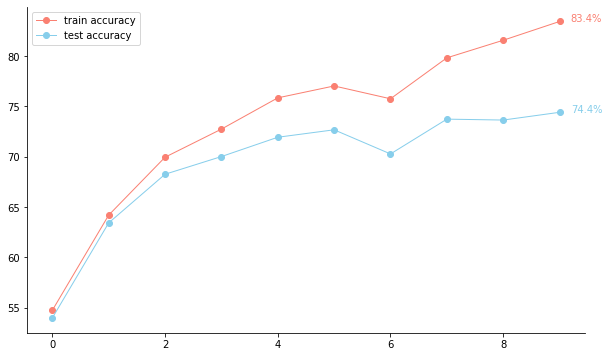

In [ ]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_acc, test_acc = train(net, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc, test_acc)

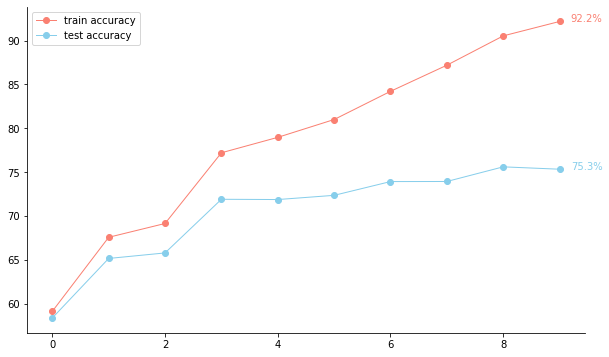

In [ ]:
net_2 = Net_2_layer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_2.parameters(), lr=0.001)

train_acc_2, test_acc_2 = train(net_2, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc_2, test_acc_2) 

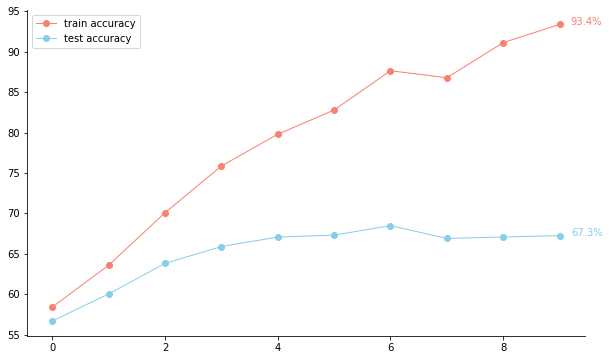

In [ ]:
net_1 = Net_1_layer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_1.parameters(), lr=0.001)

train_acc_1, test_acc_1 = train(net_1, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc_1, test_acc_1)

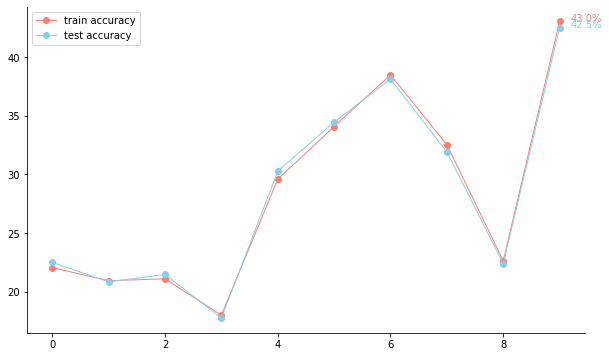

In [ ]:
net_sigmoid = Net_sigmoid()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_sigmoid.parameters(), lr=0.001)

train_acc_sigmoid, test_acc_sigmoid = train(net_sigmoid, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc_sigmoid, test_acc_sigmoid)

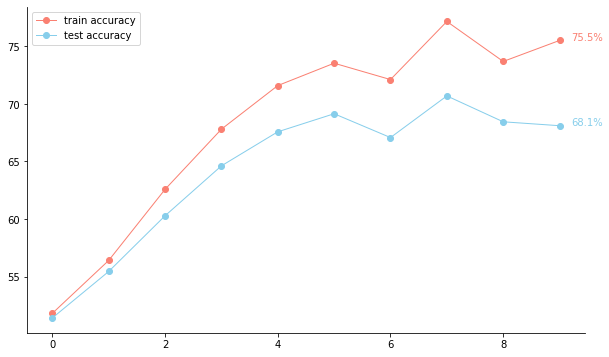

In [ ]:
net_tanh = Net_tanh()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_tanh.parameters(), lr=0.001)

train_acc_tanh, test_acc_tanh = train(net_tanh, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc_tanh, test_acc_tanh)

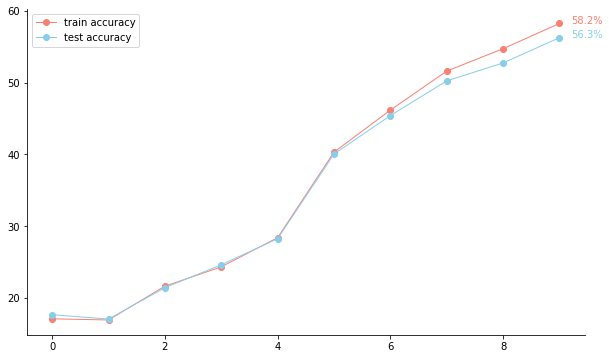

In [ ]:
net_gcd = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_gcd.parameters(), lr=0.001, momentum=0.9)

train_acc_gcd, test_acc_gcd = train(net_gcd, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc_gcd, test_acc_gcd)

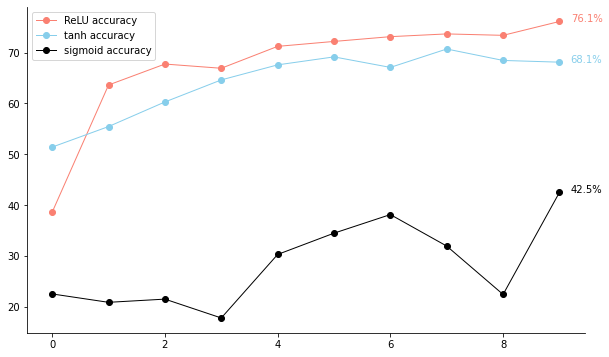

In [ ]:
plot_different_activation_acc(test_acc, test_acc_tanh, test_acc_sigmoid)

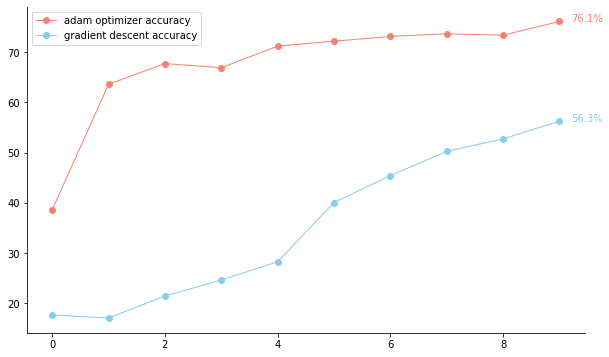

In [ ]:
plot_different_optimizer_acc(test_acc, test_acc_gcd)

### Adding Dropout to the Network

In [ ]:
# model with 3 convolutional hidden layers
class Net_dropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(nn.Dropout2d(self.dropout)(self.base(x)))
        out = self.pool(nn.Dropout2d(self.dropout)(self.layer1(out)))
        out = self.pool(nn.Dropout2d(self.dropout)(self.layer2(out)))

        out = out.reshape((out.size(0), -1))
        out = F.relu(self.fc1(out))
        out = nn.Dropout(self.dropout)(out)
        out = F.relu(self.fc2(out))
        out = nn.Dropout(self.dropout)(out)
        out = F.relu(self.fc3(out))
        out = nn.Dropout(self.dropout)(out)
        out = F.relu(self.fc4(out))
        out = nn.Dropout(self.dropout)(out)
        out = self.fc5(out)
        return out

In [ ]:
n_epochs = 10

In [ ]:
net_dropout_3 = Net_dropout(.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_dropout_3.parameters(), lr=0.001)

_, test_acc_dropout_3 = train(net_dropout_3, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

In [ ]:
test_acc_dropout_3

[17.03,
 20.61,
 20.71,
 21.36,
 23.18,
 24.83,
 27.08,
 27.26,
 28.71,
 29.14,
 29.24,
 29.61,
 30.12,
 30.89,
 30.34,
 31.44,
 31.88,
 32.07,
 31.77,
 32.51]

In [ ]:
net_dropout_2 = Net_dropout(.3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_dropout_2.parameters(), lr=0.001)

_, test_acc_dropout_2 = train(net_dropout_2, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

In [ ]:
test_acc_dropout_2

[28.23, 35.13, 38.41, 41.63, 44.83, 46.92, 47.27, 49.12, 50.34, 51.24]

In [ ]:
net_dropout_1 = Net_dropout(.1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_dropout_1.parameters(), lr=0.001)

_, test_acc_dropout_1 = train(net_dropout_1, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

In [ ]:
test_acc_dropout_1

[46.67, 53.35, 58.37, 60.23, 62.33, 62.55, 65.82, 66.51, 66.37, 66.88]

In [ ]:
net_dropout_05 = Net_dropout(.05)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_dropout_05.parameters(), lr=0.001)

_, test_acc_dropout_05 = train(net_dropout_05, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)

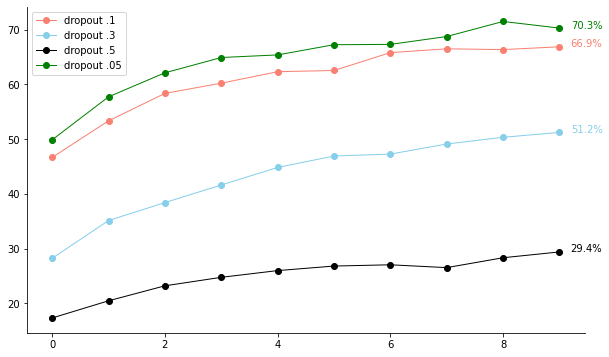

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(test_acc_dropout_1, color='salmon', label='dropout .1', marker='o', linewidth=1)
plt.annotate(str(np.round(test_acc_dropout_1[-1], 1)) + '%', (len(test_acc_dropout_1) - .8, test_acc_dropout_1[-1]), color='salmon')
plt.plot(test_acc_dropout_2, color='skyblue', label='dropout .3', marker='o', linewidth=1)
plt.annotate(str(np.round(test_acc_dropout_2[-1], 1)) + '%', (len(test_acc_dropout_2) - .8, test_acc_dropout_2[-1]), color='skyblue')
plt.plot(test_acc_dropout_3, color='black', label='dropout .5', marker='o', linewidth=1)
plt.annotate(str(np.round(test_acc_dropout_3[-1], 1)) + '%', (len(test_acc_dropout_3) - .8, test_acc_dropout_3[-1]), color='black')
plt.plot(test_acc_dropout_05, color='green', label='dropout .05', marker='o', linewidth=1)
plt.annotate(str(np.round(test_acc_dropout_05[-1], 1)) + '%', (len(test_acc_dropout_05) - .8, test_acc_dropout_05[-1]), color='green')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

### Using larger kernels instead of repeatitive ones

In [ ]:
# model with 3 convolutional hidden layers
class Net_largekernel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool(self.base(x))
        out = self.pool(self.layer1(out))
        out = self.pool(self.layer2(out))

        out = out.reshape((out.size(0), -1))
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        return out

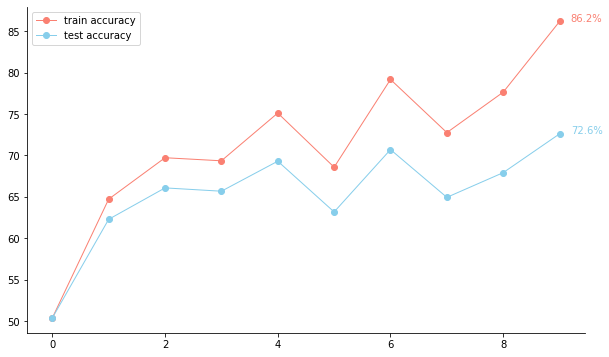

In [ ]:
net_largekernel = Net_largekernel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_largekernel.parameters(), lr=0.001)

acc_train_largekernel, acc_test_largekernel = train(net_largekernel, criterion, optimizer, train_data_loader, test_data_loader, n_epochs)
plot_train_test_acc(acc_train_largekernel, acc_test_largekernel)

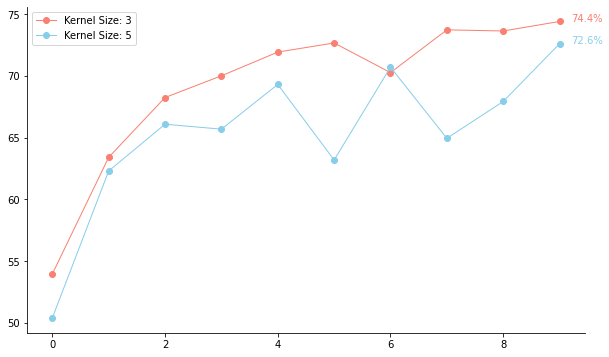

In [ ]:
plot_different_kernels(test_acc, acc_test_largekernel)

### Using 600 Samples for each class

In [ ]:
indices_to_select = np.array([], dtype=np.int64)
for index in index2label.keys():
    indices = np.where(data_labels_agg == index)[0]
    samples = np.random.choice(indices, 600, replace=False)
    indices_to_select = np.append(indices_to_select, samples, axis=0)

In [ ]:
reduced_data_array_agg = data_array_agg[indices_to_select]
reduced_data_labels_agg = data_labels_agg[indices_to_select]

In [ ]:
reduced_data_array_agg.shape, reduced_data_labels_agg.shape

((6000, 3, 32, 32), (6000,))

In [ ]:
reduced_train_data_loader = to_dataloader(reduced_data_array_agg, reduced_data_labels_agg, batch_size=128)

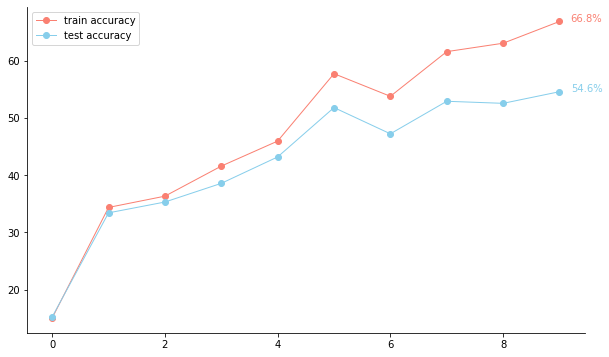

In [ ]:
net_reduced = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_reduced.parameters(), lr=0.001)

train_acc_reduced, test_acc_reduced = train(net_reduced, criterion, optimizer, reduced_train_data_loader, test_data_loader, n_epochs)

plot_train_test_acc(train_acc_reduced, test_acc_reduced)